<a href="https://www.kaggle.com/code/duynhatvo/clashroyale?scriptVersionId=93721569" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Clash Royale Dataset Analysis

## 1. Introduction

In this notebook, we are going to analyze the [Clash Royale Dataset](https://www.kaggle.com/datasets/nonrice/clash-royale-battles-upper-ladder-december-2021). This dataset documents over 700 thousands matches of the mobile game [Clash Royale](https://clashroyale.com/) by Supercell. We will first brief through the basic mechanics of the games and the goal of this project, then the analysis and conclusion part.

## 2. Objectives:
### a. Clash Royale:
Clash Royale is a realtime strategy mobile game, where 2 players fight over a 3-minute match to destroy their opponent's towers. Each player will have a prechosen deck consisting of 8 cards, and will continuously deploy their cards which are either minions or spells. The game ends after 3 minutes, or if a player's main tower is destroyed.

As simple as it may sound, analyzing who would win a match is very difficult, due to the huge permutations of cards (there are 106 cards in total), as well as the different players' skills. In this notebook, we are going to analyze the dataset with the following assumptions:
- The matches happen in a small time span (December 2021), and no update (tweaks to each card's stats) are done.
- The matches happen between the top-ranked players in the world, and they all have very similar skills.

### b. Our approach:
In this notebook, we are going to try and see whether we can predict an outcome of a match using the decks and the rank of each player.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
import json
import csv

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
battles = pd.read_csv('data/battles.csv')
print(battles[['p1_tag', 'p1_trophy', 'p2_tag', 'p2_trophy',
               'p1_crowns', 'p2_crowns', 'winner']][:5])
print("")
print("Total number of Columns:", len(list(battles.columns)))
print("Total number of Rows:", len(list(battles.index)))
print("")
print("Column Names:", list(battles.columns))

       p1_tag  p1_trophy      p2_tag  p2_trophy  p1_crowns  p2_crowns  winner
0  #C9P0L2C0Q       3071  #ULU9G9QRC       3047          0          1       2
1  #C9P0L2C0Q       3101  #C9QQ2VRGL       3100          0          3       2
2  #U8JJV8L0Q       3000  #C8G22U2VV       3019          0          3       2
3  #U8JJV8L0Q       3000  #ULU9G9QRC       3019          0          2       2
4  #U8JJV8L0Q       3000  #JGJ2L89J0       3014          0          3       2

Total number of Columns: 40
Total number of Rows: 39348

Column Names: ['Unnamed: 0', 'p1_tag', 'p1_trophy', 'p1_card_0_id', 'p1_card_0_lv', 'p1_card_1_id', 'p1_card_1_lv', 'p1_card_2_id', 'p1_card_2_lv', 'p1_card_3_id', 'p1_card_3_lv', 'p1_card_4_id', 'p1_card_4_lv', 'p1_card_5_id', 'p1_card_5_lv', 'p1_card_6_id', 'p1_card_6_lv', 'p1_card_7_id', 'p1_card_7_lv', 'p1_crowns', 'p2_tag', 'p2_trophy', 'p2_card_0_id', 'p2_card_0_lv', 'p2_card_1_id', 'p2_card_1_lv', 'p2_card_2_id', 'p2_card_2_lv', 'p2_card_3_id', 'p2_card_3_lv', 'p

As can be seen above, we have collected 1426 unique vectors of datapoints with 40 columns each that provide us with relevant information on their respective battle. 19 columns are divided each between the two players where 16 columns are for the cards with 8 each for the unique card ID and its corresponding level and out of the 3 remaining columns, 1 each for ID, trophies, and crowns. Essentially, the column names represent:
- $p\_tag$: Unique ID of the player
- $p\_trophy$: The trophies of the player (can be thought of as ranking)
- $p\_crowns$: The number of towers destroyed of by the player in the battle (max 3 == win)
- $p\_card\_x\_id$: The unique card ID of card $x$
- $p\_card\_x\_level$: The level of the corresponding card $x$
- $p\_winner$: The player who won the game

The unique card ID's have specific data points as described in the cell below where cards data is analyzed.


In [3]:
cards = pd.read_csv('data/cards.csv')
print(cards[['key', 'id', 'elixir', 'type', 'rarity']][:5])
print("")
print("Number of Columns:", len(list(cards.columns)))
print("Number of Rows:", len(list(cards.index)))
print("")
print("Column Names:", list(cards.columns))
print("")
print("Types of cards:", sorted(cards['type'].unique()))
print("Rarity of cards:", sorted(cards['rarity'].unique()))
print("Elixir for cards:", sorted(cards['elixir'].unique()))

       key        id  elixir   type  rarity
0   knight  26000000       3  Troop  Common
1  archers  26000001       3  Troop  Common
2  goblins  26000002       2  Troop  Common
3    giant  26000003       5  Troop    Rare
4    pekka  26000004       7  Troop    Epic

Number of Columns: 11
Number of Rows: 107

Column Names: ['key', 'name', 'sc_key', 'elixir', 'type', 'rarity', 'id', 'flying_height', 'range', 'damage_air', 'damage_ground']

Types of cards: ['Building', 'Spell', 'Troop']
Rarity of cards: ['Champion', 'Common', 'Epic', 'Legendary', 'Rare']
Elixir for cards: [1, 2, 3, 4, 5, 6, 7, 8, 9]


There are three ... 

Now, we create arrays for the player 1 and player 2 cards, which will be useful for later analysis.

In [4]:
p1_cols = []
p2_cols = []
for col_name in battles.columns:
    if 'p1_card_' in col_name and '_id' in col_name:
        p1_cols.append(col_name)
    elif 'p2_card_' in col_name and '_id' in col_name:
        p2_cols.append(col_name)
        
p1_cards = battles[p1_cols]
p2_cards = battles[p2_cols]
print("Player1 Column Names:", list(p1_cards.columns))
print("PLayer2 Column Names:", list(p2_cards.columns))
print("Total number of Rows:", len(list(p1_cards.index)))

Player1 Column Names: ['p1_card_0_id', 'p1_card_1_id', 'p1_card_2_id', 'p1_card_3_id', 'p1_card_4_id', 'p1_card_5_id', 'p1_card_6_id', 'p1_card_7_id']
PLayer2 Column Names: ['p2_card_0_id', 'p2_card_1_id', 'p2_card_2_id', 'p2_card_3_id', 'p2_card_4_id', 'p2_card_5_id', 'p2_card_6_id', 'p2_card_7_id']
Total number of Rows: 39348


In [5]:
# create map for card ID and row
id_map = {}
for row in cards.index:
    id_map[cards.loc[row, 'id']] = row

## 3. Preliminary Analysis:
### a. A brief overview:
We are first going to have a quick look to get a sense of the data. First, we will have a look at the dataset, and its correlation matrix to understand any relations in the datapoints.

In [6]:
battles.drop(columns='Unnamed: 0', inplace=True)

In [7]:
SIZE = 1426
df = battles.sample(20000, random_state=84)

In [8]:
df.describe()

,p1_trophy,p1_card_0_id,p1_card_0_lv,p1_card_1_id,p1_card_1_lv,p1_card_2_id,p1_card_2_lv,p1_card_3_id,p1_card_3_lv,p1_card_4_id,...,p2_card_4_id,p2_card_4_lv,p2_card_5_id,p2_card_5_lv,p2_card_6_id,p2_card_6_lv,p2_card_7_id,p2_card_7_lv,p2_crowns,winner
count,20000.000000,2.000000e+04,20000.000000,2.000000e+04,20000.000000,2.000000e+04,20000.000000,2.000000e+04,20000.000000,2.000000e+04,...,2.000000e+04,20000.000000,2.000000e+04,20000.000000,2.000000e+04,20000.000000,2.000000e+04,20000.000000,20000.000000,20000.000000
mean,3265.728450,2.637247e+07,5.214050,2.643552e+07,5.343550,2.648407e+07,5.425600,2.664317e+07,5.645150,2.665072e+07,...,2.666127e+07,5.528750,2.645932e+07,5.555550,2.645952e+07,5.612100,2.651942e+07,5.514150,1.123650,1.485750
std,1341.677224,7.536907e+05,2.899716,7.950228e+05,2.865979,8.284743e+05,2.921676,9.077083e+05,2.954567,9.076973e+05,...,9.119342e+05,2.807324,8.046525e+05,2.834205,8.053457e+05,2.876186,8.477898e+05,2.855645,1.094861,0.500209
min,23.000000,2.600000e+07,1.000000,2.600000e+07,1.000000,2.600000e+07,1.000000,2.600000e+07,1.000000,2.600000e+07,...,2.600000e+07,1.000000,2.600000e+07,1.000000,2.600000e+07,1.000000,2.600000e+07,1.000000,0.000000,0.000000
25%,2600.000000,2.600001e+07,3.000000,2.600001e+07,3.000000,2.600001e+07,3.000000,2.600001e+07,3.000000,2.600002e+07,...,2.600001e+07,3.000000,2.600001e+07,3.000000,2.600001e+07,3.000000,2.600001e+07,3.000000,0.000000,1.000000
50%,3561.500000,2.600002e+07,5.000000,2.600002e+07,5.000000,2.600002e+07,5.000000,2.600003e+07,5.000000,2.600004e+07,...,2.600004e+07,5.000000,2.600002e+07,5.000000,2.600002e+07,5.000000,2.600003e+07,5.000000,1.000000,1.000000
75%,3984.000000,2.600006e+07,7.000000,2.600007e+07,7.000000,2.700000e+07,7.000000,2.800000e+07,8.000000,2.800000e+07,...,2.800000e+07,7.000000,2.700000e+07,7.000000,2.700000e+07,8.000000,2.700001e+07,7.000000,2.000000,2.000000
max,6412.000000,2.800002e+07,14.000000,2.800002e+07,14.000000,2.800002e+07,14.000000,2.800002e+07,14.000000,2.800002e+07,...,2.800002e+07,14.000000,2.800002e+07,14.000000,2.800002e+07,14.000000,2.800002e+07,14.000000,3.000000,2.000000


In [9]:
corr = df.corr()

In [10]:
corr

,p1_trophy,p1_card_0_id,p1_card_0_lv,p1_card_1_id,p1_card_1_lv,p1_card_2_id,p1_card_2_lv,p1_card_3_id,p1_card_3_lv,p1_card_4_id,...,p2_card_4_id,p2_card_4_lv,p2_card_5_id,p2_card_5_lv,p2_card_6_id,p2_card_6_lv,p2_card_7_id,p2_card_7_lv,p2_crowns,winner
p1_trophy,1.000000,0.071542,0.338753,0.063358,0.376462,0.106477,0.386891,-0.113712,0.356019,-0.145703,...,-0.154743,0.387322,0.117572,0.383056,0.130335,0.397376,0.124937,0.384052,-0.027432,0.027733
p1_card_0_id,0.071542,1.000000,-0.027471,-0.022282,0.016828,-0.071723,0.051313,-0.070081,0.023248,-0.085374,...,-0.011397,0.014379,0.020752,0.013338,0.004794,0.019412,0.019016,0.018056,0.013265,0.018654
p1_card_0_lv,0.338753,-0.027471,1.000000,0.009080,0.343403,0.038669,0.306748,-0.022345,0.260454,0.001224,...,-0.034220,0.205438,0.029034,0.217704,0.042565,0.219652,0.021754,0.211294,-0.009329,0.013290
p1_card_1_id,0.063358,-0.022282,0.009080,1.000000,-0.069729,-0.022855,-0.017930,-0.089510,0.027371,-0.090257,...,-0.020449,0.033306,0.015125,0.019555,0.015210,0.030957,0.018030,0.017285,-0.000516,0.000895
p1_card_1_lv,0.376462,0.016828,0.343403,-0.069729,1.000000,0.027549,0.344282,-0.026006,0.289320,-0.007014,...,-0.049998,0.222731,0.041375,0.223468,0.045599,0.235684,0.032295,0.231489,-0.014049,0.010827
p1_card_2_id,0.106477,-0.071723,0.038669,-0.022855,0.027549,1.000000,-0.053862,-0.067312,0.022008,-0.103690,...,-0.021944,0.026191,0.012791,0.035154,0.010911,0.040444,0.025393,0.042536,0.026953,0.030702
p1_card_2_lv,0.386891,0.051313,0.306748,-0.017930,0.344282,-0.053862,1.000000,-0.048634,0.342073,0.001496,...,-0.057924,0.238800,0.038870,0.239427,0.051338,0.234228,0.039323,0.232166,0.015248,0.031350
p1_card_3_id,-0.113712,-0.070081,-0.022345,-0.089510,-0.026006,-0.067312,-0.048634,1.000000,-0.036109,-0.007342,...,0.024363,-0.055340,-0.026698,-0.051291,-0.013444,-0.047563,-0.020275,-0.050298,0.006465,-0.001344
p1_card_3_lv,0.356019,0.023248,0.260454,0.027371,0.289320,0.022008,0.342073,-0.036109,1.000000,-0.012193,...,-0.043371,0.223936,0.045130,0.209208,0.050332,0.225162,0.024578,0.225738,0.001152,0.022343
p1_card_4_id,-0.145703,-0.085374,0.001224,-0.090257,-0.007014,-0.103690,0.001496,-0.007342,-0.012193,1.000000,...,0.034098,-0.052119,-0.024874,-0.051795,-0.019626,-0.050444,-0.023097,-0.047977,0.015890,0.008860


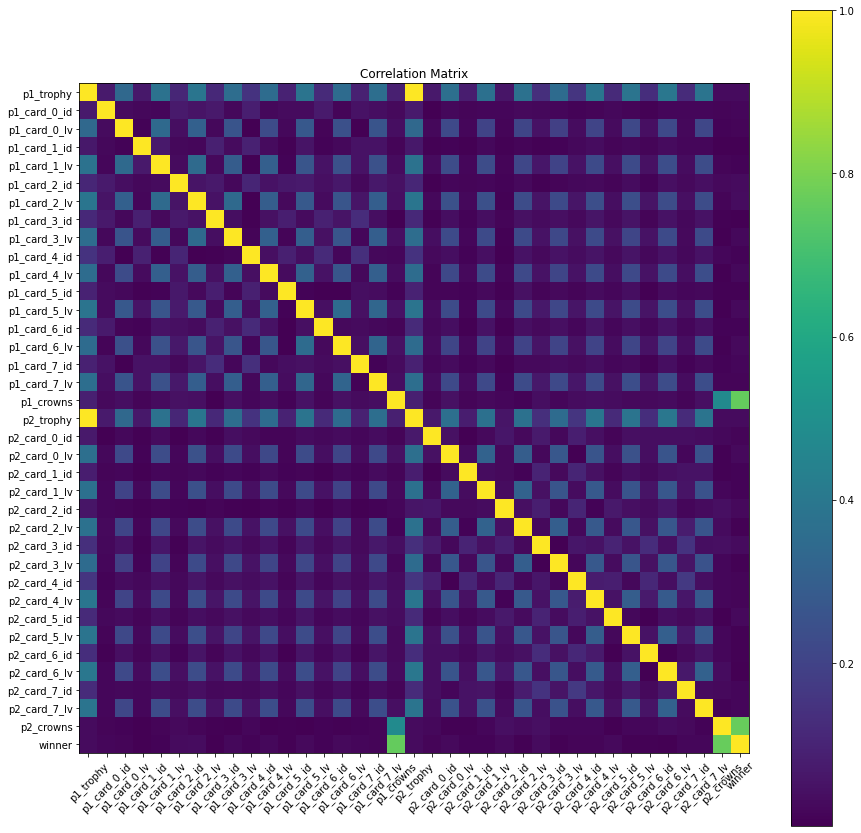

In [11]:
f = plt.figure(figsize=(15, 15))
plt.imshow(np.abs(corr))
plt.title('Correlation Matrix')
plt.xticks(np.arange(corr.shape[1]), corr.columns, rotation=45)
plt.yticks(np.arange(corr.shape[1]), corr.columns)
plt.colorbar()
plt.show()

#### Remarks:
From the plotted correlation matrix, we observe that there seems to be a clear relationship between:
- The current card and the next card(s) in each player's deck
- The players' rankings (trophies) with each other
- Players' rankings (trophies) and cards in their deck

The first relation is very intuitive. This is because cards often have synergies (i.e some go well with others as support fillers while other do not). In this case, the results can be interpreted to explain that every card is followed by another specific card to complement the first one to build a strategy (catch: this is a strategy game). There are also relationships with further cards in the deck and even though they get weaker it is straightforward to realize that the cards are played out in a specific manner to build a strategy.  

Furthermore, the players' rankings should be correlated as well which is well supported by the graph. This is so because the game's "match-making process" is based on player rankings, (and players of different rankings seems to use similar decks of cards.) --- how?

However, unfortunately, it is evident that there is almost no correlation between the outcome and any other attributes of the dataset from this analysis. We can try to apply some well-known classifications methods and check if they give us promising results.

Lets drop some columns that do not seem to be correlated to get a better picture.

In [13]:
less_cols = df
cols_to_drop = []
for col_name in df.columns:
    if 'lv' in col_name or 'tag' in col_name:
        cols_to_drop.append(col_name)
# remove cols with levels
less_cols.drop(columns=cols_to_drop, inplace=True)
less_corr = less_cols.corr()

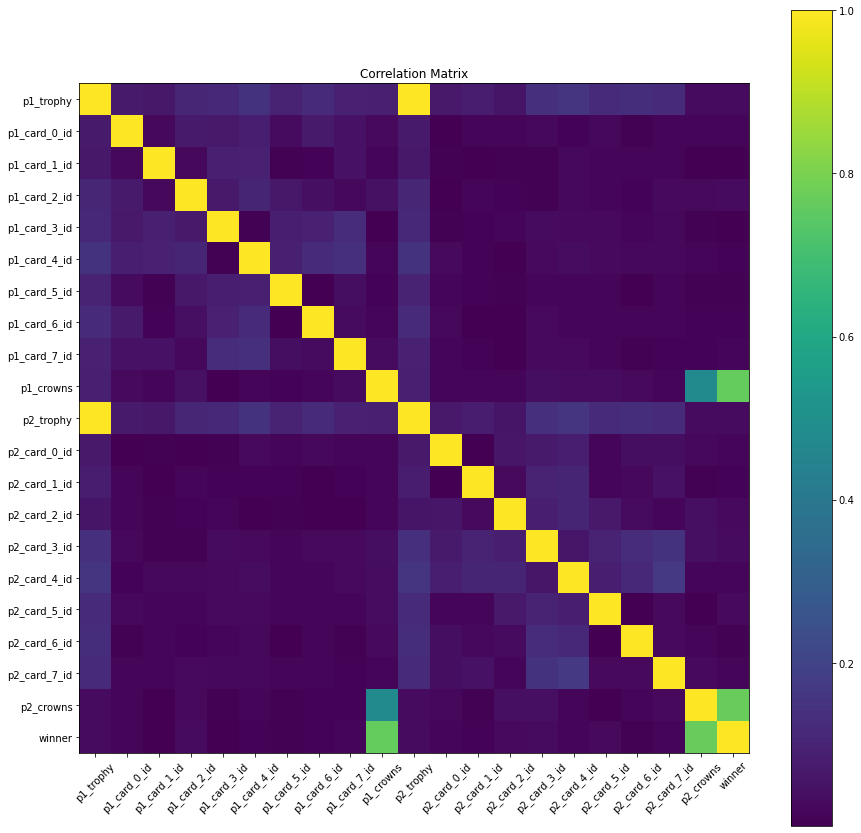

In [14]:
f = plt.figure(figsize=(15, 15))
plt.imshow(np.abs(less_corr))
plt.title('Correlation Matrix')
plt.xticks(np.arange(df.shape[1]), df.columns, rotation=45)
plt.yticks(np.arange(df.shape[1]), df.columns)
plt.colorbar()
plt.show()

### b. Understand Correlation of different features of the game

Here, we study the behaviour of three different aspects from the game based on the cards and try to see how they are related with the player who wins a particular match. These three different aspects include:
- **Average Deck Elixir**
- **Card Type**
- **Card Rarity**

**Average Deck Elixir:** In Clash Royale, every card has an elixir value which can be thought of as the cost to play that card in the game. This elixir is generated at a certain speed for every player and by playing a specific card, the elixir of that card is lost from the player's total elixir amount. This feature ensures that a player cannot play as many cards as he/she wants. In particular, this feature allows an opportunity for us to study the relation between the average elixir weight of a player's deck to the outcome of the game. In other words, our aim is to study if the player with a cheaper deck has a higher chance of winning the game. If this is the case, then we will have a correlation between the winner and the player who has cheaper deck.

**Card Type:** Every card in the game also has a type which can be thought of as a class of the card if it is a *Troop*, *Building*, or a *Spell*, and the cards do what the name of their class suggests. In particular, this feature may/may not have a relation between the type of cards of a player's deck and the outcome of the game. In other words, our aim is to study if a certain type of deck has a higher chance of winning the game. If this is the case, then we will have a correlation between the winner and the deck type. For our analysis, we will divide the *Troop* type in two categories *Air Troop* and *Ground Troop*.

**Card Rarity:** Furthermore, every card in the game also has a rarity which can be thought of as the abundance of the card in the game. Essentially there are 5 categories: *Common*, *Rare*, *Epic*, *Legendary*, and *Champion*. As the names suggest, these cards are decreasingly abundant in the game and it is harder to find these cards to upgrade their levels and play them. In particular, this is another feature that may/may not have a relation between the rarity of cards in a player's deck and the outcome of the game. In other words, our aim is to study if a certain rarity of a deck has a higher chance of winning the game. If this is the case, then we will have a correlation between the winner and the deck rarity.

In [15]:
cards_elixir = cards[['id', 'elixir']]
# create map for card ID and row
id_map = {}
for row in cards_elixir.index:
    id_map[cards_elixir.loc[row, 'id']] = row

In [16]:
p1_elixir = []
p2_elixir = []
p_elixir_greater = []

for (p1,p2) in zip(p1_cards.index, p2_cards.index):
    avg1 = 0
    avg2 = 0
    for i in range(8):
        card1 = id_map[p1_cards.iloc[p1, i]]
        card2 = id_map[p2_cards.iloc[p2, i]]

        avg1 += cards.at[card1,"elixir"]
        avg2 += cards.at[card2,"elixir"]
        
    avg1/=8.0
    avg2/=8.0
    p1_elixir.append(avg1)
    p2_elixir.append(avg2)
    if (avg1 > avg2):
        p_elixir_greater.append(1)
    elif(avg1 == avg2):
        p_elixir_greater.append(0)
    else:
        p_elixir_greater.append(2)
    

In [17]:
battles['p1_elixir'] = p1_elixir
battles['p2_elixir'] = p2_elixir
battles['p_elixir_greater'] = p_elixir_greater
df = battles[["winner", "p1_crowns", "p2_crowns", "p1_elixir", "p2_elixir", "p_elixir_greater"]]
print(df[543:549])

     winner  p1_crowns  p2_crowns  p1_elixir  p2_elixir  p_elixir_greater
543       2          0          3      2.875      3.750                 2
544       2          0          3      2.875      4.000                 2
545       2          0          1      2.875      4.500                 2
546       1          1          0      2.875      3.625                 2
547       2          0          1      3.375      3.750                 2
548       2          0          2      3.375      3.500                 2


In [18]:
corr = df.corr()

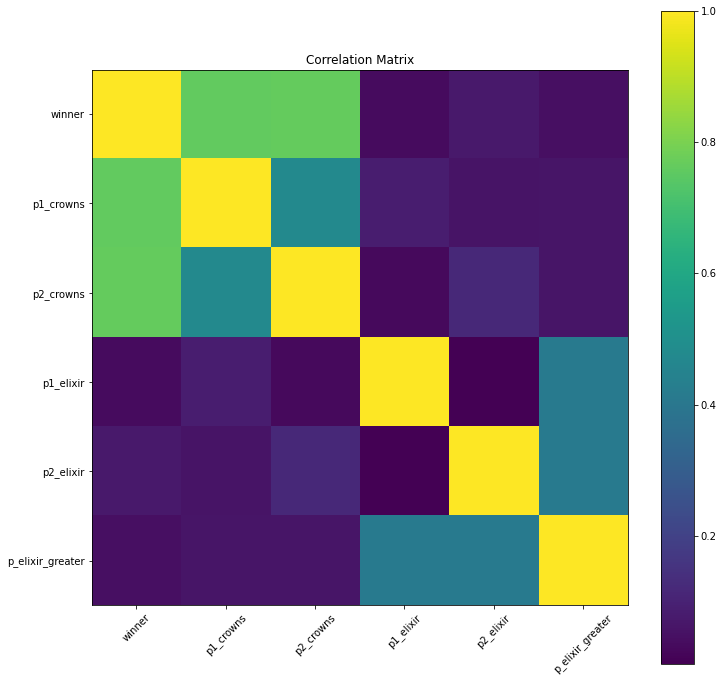

In [19]:
f = plt.figure(figsize=(12, 12))
plt.imshow(np.abs(corr))
plt.title('Correlation Matrix')
plt.xticks(np.arange(df.shape[1]), df.columns, rotation=45)
plt.yticks(np.arange(df.shape[1]), df.columns)
plt.colorbar()
plt.show()

### Troop Type

Now, we will try to analyze the decks based on the types of cards. In the original data, we have 3 types of cards: 
- $Troop$
- $Spell$ 
- $Building$ 

But, we will divide the $Troop$ type into:
- $Air\_Troop$ 
- $Ground\_Troop$

The difference between these two is that $Air\_Troop$ have $flying\_height>0$ and as the name suggests, they are positioned above 0 on the z-axis in the game. The number of $Air\_Troops$ may/may not have an effect on the result of the match and that is why we will try to train our models and see if our predictions are any better with these troop types. We modify the data accordingly in the cell below. 

In [20]:
cards = pd.read_csv('data/cards.csv')
print("Unique cards before modification:", cards['type'].unique().tolist())
print(cards[['key', 'elixir', 'type']][:5])

for row_index in cards.index:
    if cards.loc[row_index, 'type'] == 'Troop':
        if cards.loc[row_index, 'flying_height'] > 0:
            cards.loc[row_index, 'type'] = 'Air_Troop'
        else:
            cards.loc[row_index, 'type'] = 'Ground_Troop'
print("")
print("Unique cards after modification:", sorted(cards['type'].unique()))
print(cards[['key', 'elixir', 'type', 'rarity']][:5])

Unique cards before modification: ['Troop', 'Building', 'Spell']
       key  elixir   type
0   knight       3  Troop
1  archers       3  Troop
2  goblins       2  Troop
3    giant       5  Troop
4    pekka       7  Troop

Unique cards after modification: ['Air_Troop', 'Building', 'Ground_Troop', 'Spell']
       key  elixir          type  rarity
0   knight       3  Ground_Troop  Common
1  archers       3  Ground_Troop  Common
2  goblins       2  Ground_Troop  Common
3    giant       5  Ground_Troop    Rare
4    pekka       7  Ground_Troop    Epic


In [21]:
encoding_type = {'Ground_Troop': 0, 'Air_Troop': 1, 'Building': 2, 'Spell': 3}
for row_index in cards.index:
    cards.loc[row_index, 'type'] = encoding_type[cards.loc[row_index, 'type']]
print("Cards after encoding:", sorted(cards['type'].unique()))
print(cards[['key', 'elixir', 'type']][67:80])

Cards after encoding: [0, 1, 2, 3]
                 key  elixir type
67     battle-healer       4    0
68     skeleton-king       4    0
69      archer-queen       5    0
70     golden-knight       4    0
71  skeleton-dragons       4    1
72      mother-witch       4    0
73    electro-spirit       1    0
74     electro-giant       7    0
75            cannon       3    2
76        goblin-hut       5    2
77            mortar       4    2
78     inferno-tower       5    2
79        bomb-tower       4    2


### Troop Rarity 

In [22]:
print("Unique cards before modification:", cards['type'].unique().tolist())
print(cards[['key', 'elixir', 'rarity']][:5])
encoding_rarity = {'Common': 0, 'Rare': 1, 'Epic': 2, 'Legendary': 3, 'Champion': 4}
for row_index in cards.index:
    cards.loc[row_index, 'rarity'] = encoding_rarity[cards.loc[row_index, 'rarity']]
print(cards[['key', 'elixir', 'type', 'rarity']][67:85])

Unique cards before modification: [0, 1, 2, 3]
       key  elixir  rarity
0   knight       3  Common
1  archers       3  Common
2  goblins       2  Common
3    giant       5    Rare
4    pekka       7    Epic
                 key  elixir type rarity
67     battle-healer       4    0      1
68     skeleton-king       4    0      4
69      archer-queen       5    0      4
70     golden-knight       4    0      4
71  skeleton-dragons       4    1      0
72      mother-witch       4    0      3
73    electro-spirit       1    0      0
74     electro-giant       7    0      2
75            cannon       3    2      0
76        goblin-hut       5    2      1
77            mortar       4    2      0
78     inferno-tower       5    2      1
79        bomb-tower       4    2      1
80     barbarian-hut       7    2      1
81             tesla       4    2      0
82  elixir-collector       6    2      1
83             x-bow       6    2      2
84         tombstone       3    2      1


In [23]:
p1_t = []
p2_t = []
p1_r = []
p2_r = []
p_type_greater = []
p_rarity_greater = []

for (p1,p2) in zip(p1_cards.index, p2_cards.index):
    avg1_t = 0
    avg2_t = 0
    avg1_r = 0
    avg2_r = 0
    for i in range(8):
        card1 = id_map[p1_cards.iloc[p1, i]]
        card2 = id_map[p2_cards.iloc[p2, i]]

        avg1_t += cards.at[card1,"type"]
        avg2_t += cards.at[card2,"type"]
        
        avg1_r += cards.at[card1,"rarity"]
        avg2_r += cards.at[card2,"rarity"]
        
    avg1_t/=8.0
    avg2_t/=8.0
    p1_t.append(avg1_t)
    p2_t.append(avg2_t)
    if (avg1_t > avg2_t):
        p_type_greater.append(1)
    elif(avg1_t == avg2_t):
        p_type_greater.append(0)
    else:
        p_type_greater.append(2)
        
    avg1_r/=8.0
    avg2_r/=8.0
    p1_r.append(avg1_r)
    p2_r.append(avg2_r)
    if (avg1_t > avg2_t):
        p_rarity_greater.append(1)
    elif(avg1_t == avg2_t):
        p_rarity_greater.append(0)
    else:
        p_rarity_greater.append(2)
    

In [24]:
battles['p1_type'] = p1_t
battles['p2_type'] = p2_t
battles['p_type_greater'] = p_type_greater
battles['p1_rarity'] = p1_r
battles['p2_rarity'] = p2_r
battles['p_rarity_greater'] = p_type_greater
df = battles[["winner", "p1_crowns", "p2_crowns", "p1_elixir", "p2_elixir", "p_elixir_greater",
             "p1_type", "p2_type", "p_type_greater", "p1_rarity", "p2_rarity", "p_rarity_greater"]]
print(df[543:549])

     winner  p1_crowns  p2_crowns  p1_elixir  p2_elixir  p_elixir_greater  \
543       2          0          3      2.875      3.750                 2   
544       2          0          3      2.875      4.000                 2   
545       2          0          1      2.875      4.500                 2   
546       1          1          0      2.875      3.625                 2   
547       2          0          1      3.375      3.750                 2   
548       2          0          2      3.375      3.500                 2   

     p1_type  p2_type  p_type_greater  p1_rarity  p2_rarity  p_rarity_greater  
543    1.000    1.000               0      1.375      1.625                 0  
544    1.000    0.750               1      1.375      1.625                 1  
545    1.000    1.000               0      1.375      1.625                 0  
546    1.000    1.125               2      1.375      1.500                 2  
547    1.375    0.750               1      0.875      1.625 

In [25]:
corr_var = df.corr()

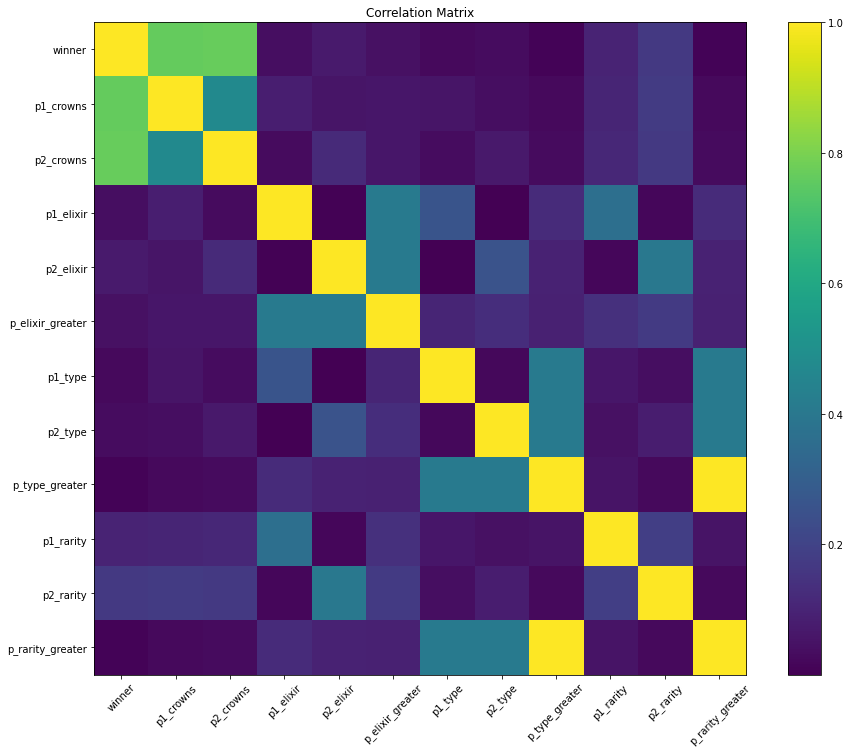

In [26]:
f = plt.figure(figsize=(15, 12))
plt.imshow(np.abs(corr_var))
plt.title('Correlation Matrix')
plt.xticks(np.arange(df.shape[1]), df.columns, rotation=45)
plt.yticks(np.arange(df.shape[1]), df.columns)
plt.colorbar()
plt.show()

### Remark

From this matrix we can see that there is a clear correlation between $p\_type\_greater$ and $p\_rarity\_greater$. This essentially means that the player who has more spells

This time we add weights to the types and rarity of the cards and see if that gives a better relation.

In [27]:
nb_rarity = [0, 0, 0, 0, 0]
nb_type = [0, 0, 0, 0]
for row in cards.index:
    nb_rarity[cards.loc[row, 'rarity']] += 1
    nb_type[cards.loc[row, 'type']] += 1
    
nb_rarity = [i/107.0 for i in nb_rarity]
nb_type = [i/107.0 for i in nb_type]
print(sum(nb_type))
print(sum(nb_rarity))

1.0
1.0


In [28]:
cards = pd.read_csv('data/cards.csv')
for row_index in cards.index:
#     print(cards.loc[row_index])
    if cards.loc[row_index, 'type'] == 'Troop':
        if cards.loc[row_index, 'flying_height'] > 0:
            cards.loc[row_index, 'type'] = 'Air_Troop'
        else:
            cards.loc[row_index, 'type'] = 'Ground_Troop'
            
for i, val in enumerate(sorted(encoding_rarity)):
    encoding_rarity[val] = nb_rarity[i]
    print(encoding_rarity[val])
    
for i, val in enumerate(sorted(encoding_type)):
    encoding_type[val] = nb_type[i]

for row_index in cards.index:
    cards.loc[row_index, 'rarity'] = encoding_rarity[cards.loc[row_index, 'rarity']]
    cards.loc[row_index, 'type'] = encoding_type[cards.loc[row_index, 'type']]
    
print(cards[['key', 'elixir', 'type', 'rarity']][67:72])
print("Types of cards:", sorted(cards['type'].unique()), " Sum: ", sum(cards['type'].unique()))
print("Rarity of cards:", sorted(cards['rarity'].unique()), " Sum: ", sum(cards['rarity'].unique()))


0.2616822429906542
0.2616822429906542
0.27102803738317754
0.16822429906542055
0.037383177570093455
                 key  elixir      type    rarity
67     battle-healer       4  0.121495  0.037383
68     skeleton-king       4  0.121495  0.261682
69      archer-queen       5  0.121495  0.261682
70     golden-knight       4  0.121495  0.261682
71  skeleton-dragons       4  0.598131  0.261682
Types of cards: [0.11214953271028037, 0.12149532710280374, 0.16822429906542055, 0.5981308411214953]  Sum:  1.0
Rarity of cards: [0.037383177570093455, 0.16822429906542055, 0.2616822429906542, 0.27102803738317754]  Sum:  0.7383177570093458


In [29]:
# weighted average over all readings
p1_tw = []
p2_tw = []
p1_rw = []
p2_rw = []
p_type_greater = []
p_rarity_greater = []

for (p1,p2) in zip(p1_cards.index, p2_cards.index):
    avg1_tw = 0
    avg2_tw = 0
    avg1_rw = 0
    avg2_rw = 0
    for i in range(8):
        card1 = id_map[p1_cards.iloc[p1, i]]
        card2 = id_map[p2_cards.iloc[p2, i]]

        avg1_tw += cards.at[card1,"type"]
        avg2_tw += cards.at[card2,"type"]
        
        avg1_rw += cards.at[card1,"rarity"]
        avg2_rw += cards.at[card2,"rarity"]
        
    avg1_tw/=8.0
    avg2_tw/=8.0
    p1_tw.append(avg1_tw)
    p2_tw.append(avg2_tw)
    if (avg1_tw > avg2_tw):
        p_type_greater.append(1)
    elif(avg1_tw == avg2_tw):
        p_type_greater.append(0)
    else:
        p_type_greater.append(2)
        
    avg1_rw/=8.0
    avg2_rw/=8.0
    p1_rw.append(avg1_rw)
    p2_rw.append(avg2_rw)
    if (avg1_tw > avg2_tw):
        p_rarity_greater.append(1)
    elif(avg1_tw == avg2_tw):
        p_rarity_greater.append(0)
    else:
        p_rarity_greater.append(2)

In [30]:
battles['p1_wtype'] = p1_tw
battles['p2_wtype'] = p2_tw
battles['p_w_type_greater'] = p_type_greater
battles['p1_wrarity'] = p1_rw
battles['p2_wrarity'] = p2_rw
battles['p_w_rarity_greater'] = p_type_greater
df = battles[["winner", "p1_crowns", "p2_crowns", "p1_elixir", "p2_elixir", "p_elixir_greater",
             "p1_type", "p2_type", "p_type_greater", "p1_rarity", "p2_rarity", "p_rarity_greater",
             "p1_wtype", "p2_wtype", "p_w_type_greater", "p1_wrarity", "p2_wrarity", "p_w_rarity_greater"]]
print(df[543:549])

     winner  p1_crowns  p2_crowns  p1_elixir  p2_elixir  p_elixir_greater  \
543       2          0          3      2.875      3.750                 2   
544       2          0          3      2.875      4.000                 2   
545       2          0          1      2.875      4.500                 2   
546       1          1          0      2.875      3.625                 2   
547       2          0          1      3.375      3.750                 2   
548       2          0          2      3.375      3.500                 2   

     p1_type  p2_type  p_type_greater  p1_rarity  p2_rarity  p_rarity_greater  \
543    1.000    1.000               0      1.375      1.625                 0   
544    1.000    0.750               1      1.375      1.625                 1   
545    1.000    1.000               0      1.375      1.625                 0   
546    1.000    1.125               2      1.375      1.500                 2   
547    1.375    0.750               1      0.875      1

In [31]:
corr_wvar = df.corr()

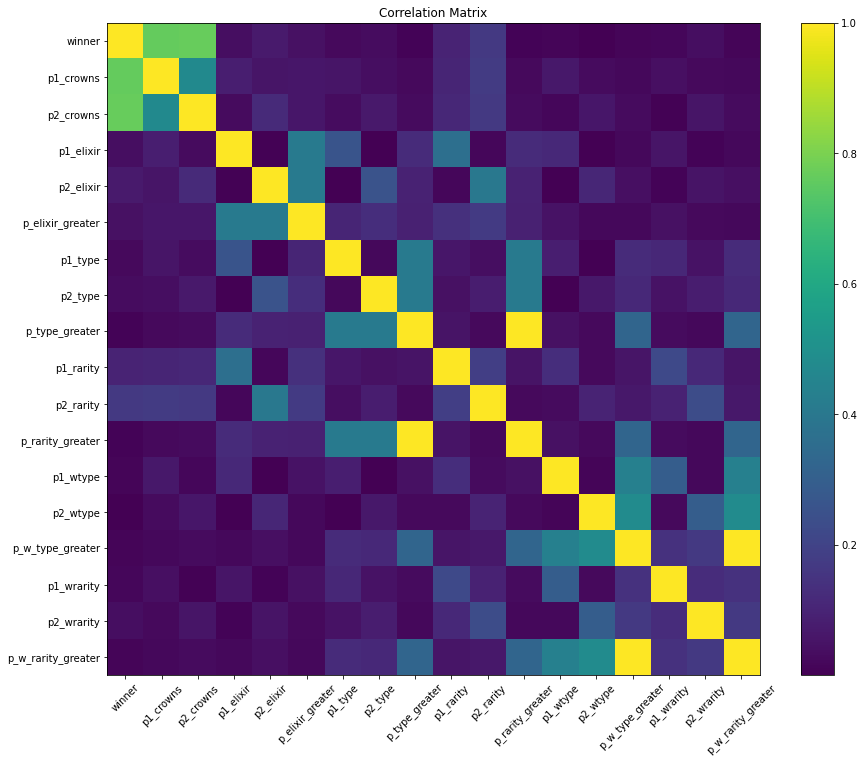

In [32]:
f = plt.figure(figsize=(15, 12))
plt.imshow(np.abs(corr_wvar))
plt.title('Correlation Matrix')
plt.xticks(np.arange(df.shape[1]), df.columns, rotation=45)
plt.yticks(np.arange(df.shape[1]), df.columns)
plt.colorbar()
plt.show()

### c. Basic Algorithms:
In the following cells we do the following:
1. We first encode each players' deck into $1 \times 106$ vectors, where $V_i = 1$ if the $i^{th}$ card is in the deck, $0$ otherwise. This seems to be a better choice than one-hot encoding, as there are $\begin{pmatrix}106 \\ 8 \end{pmatrix} \approx 3 \times 10^{11}$ possible choices of decks.
2. We then split the whole data set into training sets and test sets for supervised classification. We also keep a list of all decks choice people used to see if unsupervised learning give us some better insights into the data set.
3. We then apply some well-known simple Classification methods (e.g KNN, Decsion Trees, etc.) to see if we get a good result.

In [88]:
from sklearn.model_selection import train_test_split
df = battles[(battles['p1_trophy'] < 2700) & (battles['p1_trophy'] > 600)]

y_train = df['winner']
x_train, decks = [], []

# we first combine the DataFrame into 1x106 vectors, where V[i] = 1 if the ith card is in the deck
# this 
for i in df.index:
    p1 = np.zeros(107)
    p2 = np.zeros(107)
    for j in range(0, 8):
        p1[id_map[df[f'p1_card_{j}_id'][i]]] = 1
        p2[id_map[df[f'p2_card_{j}_id'][i]]] = 1
    decks.append(p1)
    decks.append(p2)
    x_train.append(np.concatenate((p1, p2)))
    
x_train = np.array(x_train)
decks = np.array(decks)
y_train = df['winner']

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=6233)
# d_train, d_test = train_test_split(decks, test_size=0.2, random_state=47483)

In [89]:
df.columns

Index(['p1_tag', 'p1_trophy', 'p1_card_0_id', 'p1_card_0_lv', 'p1_card_1_id',
       'p1_card_1_lv', 'p1_card_2_id', 'p1_card_2_lv', 'p1_card_3_id',
       'p1_card_3_lv', 'p1_card_4_id', 'p1_card_4_lv', 'p1_card_5_id',
       'p1_card_5_lv', 'p1_card_6_id', 'p1_card_6_lv', 'p1_card_7_id',
       'p1_card_7_lv', 'p1_crowns', 'p2_tag', 'p2_trophy', 'p2_card_0_id',
       'p2_card_0_lv', 'p2_card_1_id', 'p2_card_1_lv', 'p2_card_2_id',
       'p2_card_2_lv', 'p2_card_3_id', 'p2_card_3_lv', 'p2_card_4_id',
       'p2_card_4_lv', 'p2_card_5_id', 'p2_card_5_lv', 'p2_card_6_id',
       'p2_card_6_lv', 'p2_card_7_id', 'p2_card_7_lv', 'p2_crowns', 'winner',
       'p1_elixir', 'p2_elixir', 'p_elixir_greater', 'p1_type', 'p2_type',
       'p_type_greater', 'p1_rarity', 'p2_rarity', 'p_rarity_greater',
       'p1_wtype', 'p2_wtype', 'p_w_type_greater', 'p1_wrarity', 'p2_wrarity',
       'p_w_rarity_greater'],
      dtype='object')

In [90]:
df.describe()

,p1_trophy,p1_card_0_id,p1_card_0_lv,p1_card_1_id,p1_card_1_lv,p1_card_2_id,p1_card_2_lv,p1_card_3_id,p1_card_3_lv,p1_card_4_id,...,p_type_greater,p1_rarity,p2_rarity,p_rarity_greater,p1_wtype,p2_wtype,p_w_type_greater,p1_wrarity,p2_wrarity,p_w_rarity_greater
count,9367.000000,9.367000e+03,9367.000000,9.367000e+03,9367.000000,9.367000e+03,9367.000000,9.367000e+03,9367.000000,9.367000e+03,...,9367.000000,9367.000000,9367.000000,9367.000000,9367.000000,9367.000000,9367.000000,9367.000000,9367.000000,9367.000000
mean,1783.041208,2.632851e+07,4.145618,2.639117e+07,4.370343,2.639577e+07,4.406000,2.667099e+07,4.673535,2.673653e+07,...,1.310985,1.410497,1.321901,1.310985,0.193570,0.193320,1.437493,0.181511,0.179232,1.437493
std,660.778457,7.136570e+05,2.165316,7.642676e+05,2.173803,7.699157e+05,2.193914,9.246562e+05,2.307034,9.344069e+05,...,0.682997,0.384599,0.422744,0.682997,0.040387,0.041510,0.573747,0.035902,0.033559,0.573747
min,601.000000,2.600000e+07,1.000000,2.600000e+07,1.000000,2.600000e+07,1.000000,2.600000e+07,1.000000,2.600000e+07,...,0.000000,0.250000,0.000000,0.000000,0.112150,0.112150,0.000000,0.065421,0.066589,0.000000
25%,1151.000000,2.600001e+07,3.000000,2.600001e+07,3.000000,2.600001e+07,3.000000,2.600001e+07,3.000000,2.600001e+07,...,1.000000,1.125000,1.125000,1.000000,0.185748,0.185748,1.000000,0.153037,0.153037,1.000000
50%,1744.000000,2.600002e+07,4.000000,2.600002e+07,4.000000,2.600002e+07,4.000000,2.600002e+07,5.000000,2.600003e+07,...,1.000000,1.375000,1.375000,1.000000,0.191589,0.192757,1.000000,0.181075,0.179907,1.000000
75%,2483.000000,2.600004e+07,6.000000,2.600005e+07,6.000000,2.600004e+07,6.000000,2.800000e+07,7.000000,2.800000e+07,...,2.000000,1.750000,1.625000,2.000000,0.198598,0.198598,2.000000,0.209112,0.199766,2.000000
max,2699.000000,2.800002e+07,11.000000,2.800002e+07,11.000000,2.800002e+07,10.000000,2.800002e+07,11.000000,2.800002e+07,...,2.000000,2.500000,3.000000,2.000000,0.419393,0.598131,2.000000,0.269860,0.271028,2.000000


In [91]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

In [92]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
print('Training accuracy:\t', knn.score(x_train, y_train))
print('Testing accuracy:\t', knn.score(x_test, y_test))

Training accuracy:	 0.7377552382223409
Testing accuracy:	 0.5811099252934898


In [93]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20))
ada.fit(x_train, y_train)
print('Training accuracy:\t', ada.score(x_train, y_train))
print('Testing accuracy:\t', ada.score(x_test, y_test))

Training accuracy:	 0.9971973842252769
Testing accuracy:	 0.5901814300960512


In [94]:
bagging = BaggingClassifier(DecisionTreeClassifier(max_depth=20))
bagging.fit(x_train, y_train)
print('Training accuracy:\t', bagging.score(x_train, y_train))
print('Testing accuracy:\t', bagging.score(x_test, y_test))

Training accuracy:	 0.9514213265714667
Testing accuracy:	 0.5891141942369263


In [95]:
extra = ExtraTreesClassifier(max_depth=20)
extra.fit(x_train, y_train)
print('Training accuracy:\t', extra.score(x_train, y_train))
print('Testing accuracy:\t', extra.score(x_test, y_test))

Training accuracy:	 0.9929267316161751
Testing accuracy:	 0.6045891141942369


In [96]:
rf = RandomForestClassifier(max_depth=20)
rf.fit(x_train, y_train)
print('Training accuracy:\t', rf.score(x_train, y_train))
print('Testing accuracy:\t', rf.score(x_test, y_test))

Training accuracy:	 0.9869211263846257
Testing accuracy:	 0.5960512273212379


#### Remarks:
Unfortunately, our models does not seem to have a good predictions overall (the score is only a bit better than random guessing). In the following parts of the notebook, we are going to see if we could obtain a better fit on this dataset.

## 4. Decks Analysis:
Let us dig deeper into the dataset by analyzing the decks, which seems to be most correlated.

We first visualize the correlation matrix (now with the new encoding).

/users/eleves-b/2020/nhat.vo/.conda/envs/CSE204/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/users/eleves-b/2020/nhat.vo/.conda/envs/CSE204/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


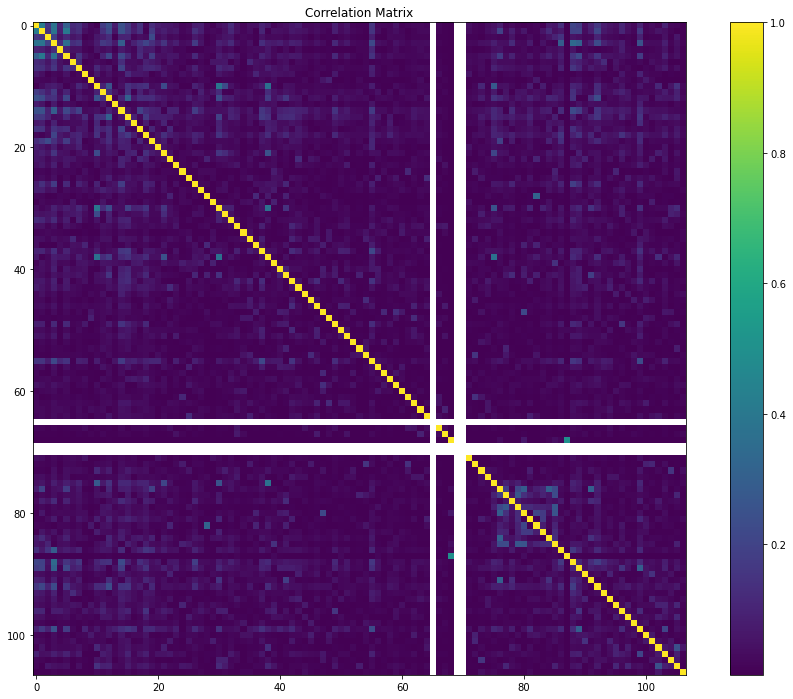

In [44]:
d_corr = np.corrcoef(decks.T)
f = plt.figure(figsize=(16, 12))
plt.imshow(np.abs(d_corr))
plt.title('Correlation Matrix')
plt.colorbar()
plt.show()

#### Remarks:
We want to observe which pairs have the highest synergy. The following cells sets all correlation under the diagonal to 0, and sort them by value.

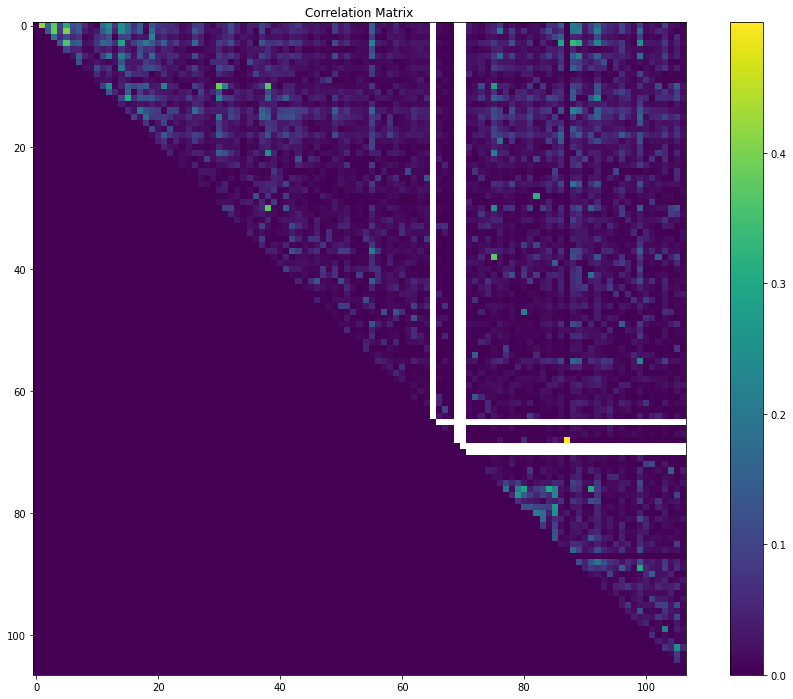

In [45]:
d_corr_u = np.triu(d_corr, k=1)
d_corr_u
f = plt.figure(figsize=(16, 12))
plt.imshow(np.abs(d_corr_u))
plt.title('Correlation Matrix')
plt.colorbar()
plt.show()

In [46]:
id_map_inv = {}
for i in id_map:
    id_map_inv[id_map[i]] = i
d_corr_flat = d_corr_u.flatten()
d_corr_argsort = np.argsort(d_corr_flat)
d_corr_high = [(x // 106, x % 106, d_corr_flat[x]) for x in d_corr_argsort[:-31:-1]]
d_corr_low = [(x // 106, x % 106, d_corr_flat[x]) for x in d_corr_argsort[:30]]

In [47]:
[(cards[id_map[x]], cards[id_map[y]], z) for (x, y, z) in d_corr_high]

KeyError: 71

In [48]:
[(cards[x], cards[y], z) for (x, y, z) in d_corr_low]

KeyError: 90

#### Remarks:
We observe that these card pairs are very common in the strongest decks (from https://www.deckshop.pro/).

## 5. A deeper look at Outcome:
### a. Applying PCA:

In [49]:
data = np.copy(x_train).T.tolist()
data.append(y_train)
data = np.array(data)

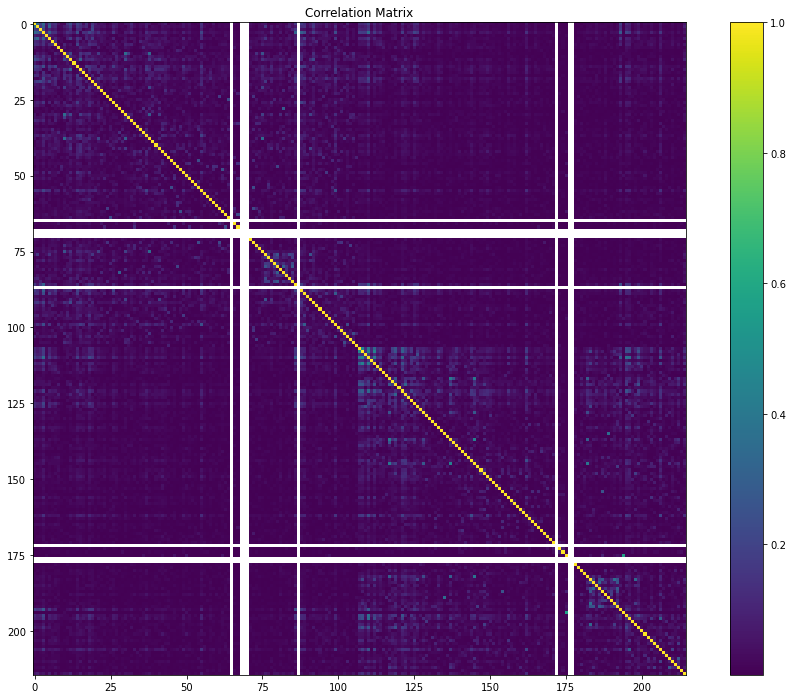

In [50]:
corr = np.corrcoef(data)
f = plt.figure(figsize=(16, 12))
plt.imshow(np.abs(corr))
plt.title('Correlation Matrix')
plt.colorbar()
plt.show()

In [64]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
x_train_pca = pca.fit_transform(x_train)

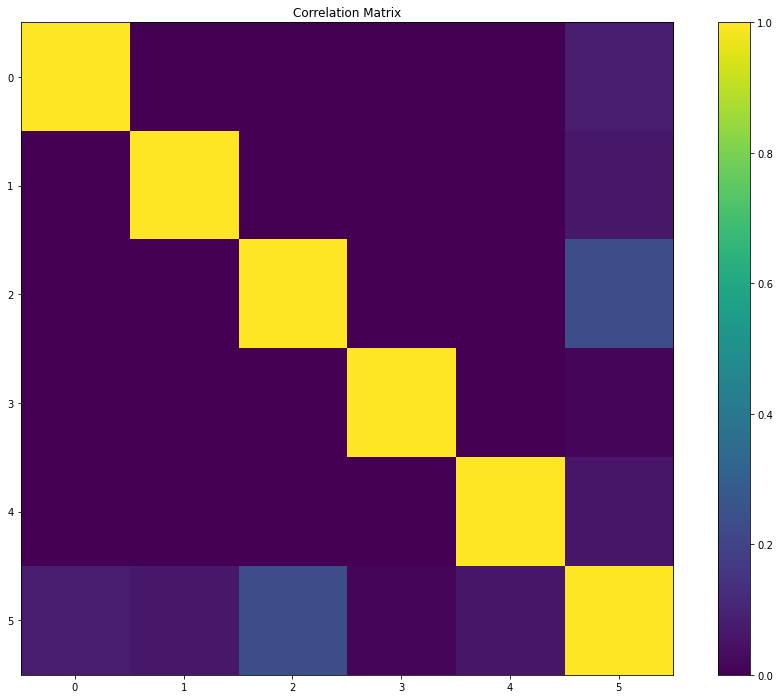

In [65]:
data = np.copy(x_train_pca).T.tolist()
data.append(y_train)
data = np.array(data)
corr = np.corrcoef(data)
f = plt.figure(figsize=(16, 12))
plt.imshow(np.abs(corr))
plt.title('Correlation Matrix')
plt.colorbar()
plt.show()

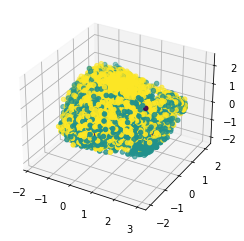

In [66]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x_train_pca[:,0].flatten(), x_train_pca[:, 1].flatten(), x_train_pca[:, 2].flatten(), c = y_train.tolist())

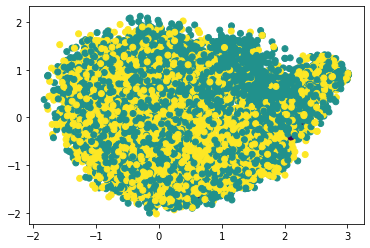

In [67]:
plt.scatter(x_train_pca[:,0].flatten(), x_train_pca[:, 1].flatten(), c = y_train.tolist())

In [71]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20))
ada.fit(x_train_pca, y_train)
print('Training accuracy:\t', ada.score(x_train_pca, y_train))
print('Testing accuracy:\t', ada.score(pca.transform(x_test), y_test))

Training accuracy:	 0.9965511440107672
Testing accuracy:	 0.5660218671152228


In [72]:
extra = ExtraTreesClassifier(max_depth=20)
extra.fit(x_train_pca, y_train)
print('Training accuracy:\t', extra.score(x_train_pca, y_train))
print('Testing accuracy:\t', extra.score(pca.transform(x_test), y_test))

Training accuracy:	 0.9929761103633916
Testing accuracy:	 0.5798149705634987


In [73]:
rf = RandomForestClassifier(max_depth=20)
rf.fit(x_train_pca, y_train)
print('Training accuracy:\t', rf.score(x_train_pca, y_train))
print('Testing accuracy:\t', rf.score(pca.transform(x_test), y_test))

Training accuracy:	 0.9906207940780619
Testing accuracy:	 0.5729184188393608


In [77]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(x_train, y_train)
print('Training accuracy:\t', gnb.score(x_train, y_train))
print('Testing accuracy:\t', gnb.score(x_test, y_test))

Training accuracy:	 0.5908899730820996
Testing accuracy:	 0.5801513877207738


### b. How about Neural Network?
Let's try to see if we can instead obtain a good score using Neural Network. 

We first try a naive Neural Network, with all layers are dense, and two Dropouts.

In [57]:
y_train

11045    2
24536    2
1586     1
29306    1
33426    1
        ..
31066    1
16878    1
25671    2
13065    1
24195    2
Name: winner, Length: 23776, dtype: int64

In [58]:
from tensorflow import keras
nn = keras.Sequential([
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=2)
nn.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=['accuracy'],
)
nn.fit(x_train, y_train-1, validation_split=0.1, epochs=10, batch_size=16, callbacks=[early_stopping])

2022-04-28 21:47:37.351972: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-04-28 21:47:37.366291: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 3504000000 Hz
2022-04-28 21:47:37.367261: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55bf3ddf0fb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-04-28 21:47:37.367283: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-04-28 21:47:37.367380: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1338/1338 [==============================] - 3s 3ms/step - loss: 0.7495 - accuracy: 0.5124 - val_loss: 0.7016 - val_accuracy: 0.5421
Epoch 2/10
1338/1338 [==============================] - 3s 2ms/step - loss: 0.7391 - accuracy: 0.5169 - val_loss: 0.6974 - val_accuracy: 0.5425
Epoch 3/10
1338/1338 [==============================] - 3s 2ms/step - loss: 0.7320 - accuracy: 0.5197 - val_loss: 0.6930 - val_accuracy: 0.5521
Epoch 4/10
1338/1338 [==============================] - 3s 2ms/step - loss: 

In [59]:
nn.evaluate(x_test, y_test-1)

186/186 [==============================] - 0s 1ms/step - loss: 0.6804 - accuracy: 0.5442


[0.6803574562072754, 0.5441547632217407]

#### Remarks: 
The previous one did not really give a very good score, so let's try to see if we could use a different network structure.

Through the previous analysis on Decks, we observe that a deck is characterized by a small number of cards. With that in mind, it makes sense to use CNN on this model, as in the following cell.

In [63]:
from tensorflow import keras
cnn = keras.Sequential([
    keras.layers.Dense(212, activation='relu'),
#     keras.layers.Conv1D(32, 4, padding='same', activation='relu'),
#     keras.layers.Conv1D(32, 4, activation='relu'),
#     keras.layers.Dropout(0.2),
#     keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool1D(8),
#     keras.layers.Conv1D(64, 4, activation='relu'),
#     keras.layers.Conv1D(64, 4, activation='relu'),
#     keras.layers.Dropout(0.2),
#     keras.layers.BatchNormalization(),
    
    keras.layers.Dense(128, activation='relu'),
    keras.layers.MaxPool1D(8),
    keras.layers.Dense(32, activation='relu'),
#     keras.layers.Dropout(0.2),
#     keras.layers.BatchNormalization(),
    keras.layers.Dense(16, activation='relu'),
#     keras.layers.Dropout(0.2),
#     keras.layers.BatchNormalization(),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])
early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)
cnn.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=['accuracy'],
)
# x_train = x_train.to_numpy()
cnn.fit(x_train.reshape((x_train.shape[0], x_train.shape[1], 1)), y_train-1, validation_split=0.1, epochs=30, batch_size=16, callbacks=[early_stopping])
# cnn.fit(x_train, y_train-1, validation_split=0.1, epochs=30, batch_size=16, callbacks=[early_stopping])

Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1338/1338 [==============================] - 7s 6ms/step - loss: 0.6932 - accuracy: 0.5064 - val_loss: 0.6919 - val_accuracy: 0.5336
Epoch 2/30
1338/1338 [==============================] - 7s 5ms/step - loss: 0.6925 - accuracy: 0.5201 - val_loss: 0.6916 - val_accuracy: 0.5336
Epoch 3/30
1338/1338 [==============================] - 7s 6ms/step - loss: 0.6924 - accuracy: 0.5201 - val_loss: 0.6915 - val_accuracy: 0.5336
Epoch 4/30
1338/1338 [==============================] - 8s 6ms/step - loss: 

In [ ]:
cnn.evaluate(x_test.reshape((x_test.shape[0], x_test.shape[1], 1)), y_test)

#### Remarks:
The result indeed looks much better than our naive model. We observe that indeed, it is better to look at a match in terms of the main cards used in each battle.

However, it appears that, unfortunately, we cannot really get a much better prediction of outcome than decision trees.

Still, with our previous analysis, it seems that we could try and get a good result at deck building.

## 6. Deck Building:

In [ ]:
N_CARDS = 107
synergies = np.array([(i, j, d_corr[i][j]) for i in range(N_CARDS) for j in range(i+1, N_CARDS)])

In [ ]:
import seaborn as sns
x_train, y_train = synergies[:, :2], synergies[:, 2]
fig = plt.figure(figsize=(12, 8))
sns.histplot(y_train)